In [1]:
import matplotlib.pyplot as plt
import h5py
import healpy as hp
import yaml 
import time 
import numpy as np

In [2]:
import pickle
from estats.map import map
from estats.summary import summary

In [3]:
#test for fiducial or cosmo from the grid
cosmo = 'cosmo_002835'

In [4]:
index_perm = 2

In [5]:
#list_reals = ['/global/cfs/cdirs/des/cosmogrid/DESY3/fiducial/cosmo_fiducial/perm_{file_num:04d}/projected_probes_maps_nobaryons512.h5'.format(file_num=m) for m in range(199)]
list_reals = ['/global/cfs/cdirs/des/cosmogrid/DESY3/grid/{}/perm_{file_num:04d}/projected_probes_maps_nobaryons512.h5'.format(cosmo, file_num=m) for m in range(199)]

In [6]:
list_reals[index_perm]

'/global/cfs/cdirs/des/cosmogrid/DESY3/grid/cosmo_002835/perm_0002/projected_probes_maps_nobaryons512.h5'

In [7]:
no_baryons= h5py.File(list_reals[index_perm], "r")

In [8]:
kg_nobaryons = no_baryons['kg']
dg_nobaryons = no_baryons['dg']
ia_nobaryons = no_baryons['ia']

In [9]:
dg_nobaryons.keys()

<KeysViewHDF5 ['desy3maglim1', 'desy3maglim2', 'desy3maglim3', 'desy3maglim4', 'desy3maglim5', 'desy3maglim6', 'desy3metacal1', 'desy3metacal2', 'desy3metacal3', 'desy3metacal4']>

In [10]:
#substract the mean 
def sub_mean_kappa(x):
    return x - np.mean(x)
#constrast
def sub_mean_delta(x):
    return (x - np.mean(x))/np.mean(x)

In [11]:
list_metacal = list(no_baryons['kg'].keys())
list_maglim = ['desy3maglim1', 'desy3maglim2', 'desy3maglim3', 'desy3maglim4', 'desy3maglim5', 'desy3maglim6']

2023-02-09 07:38:44,321 -       map.py: 799 - WARNING - Weights not set for instance 0. Using equal weighting.
2023-02-09 07:38:50,276 -   summary.py: 985 -    INFO - Down sampled data vectors for statistic Peaks from 1000 bins to 50 bins
2023-02-09 07:39:00,170 -       map.py: 799 - WARNING - Weights not set for instance 0. Using equal weighting.
2023-02-09 07:39:04,984 -   summary.py: 985 -    INFO - Down sampled data vectors for statistic Peaks from 1000 bins to 50 bins
2023-02-09 07:39:13,167 -       map.py: 799 - WARNING - Weights not set for instance 0. Using equal weighting.
2023-02-09 07:39:17,976 -   summary.py: 985 -    INFO - Down sampled data vectors for statistic Peaks from 1000 bins to 50 bins
2023-02-09 07:39:35,314 -       map.py: 799 - WARNING - Weights not set for instance 0. Using equal weighting.
2023-02-09 07:39:41,054 -   summary.py: 985 -    INFO - Down sampled data vectors for statistic Peaks from 1000 bins to 50 bins
2023-02-09 07:39:49,384 -       map.py: 799 

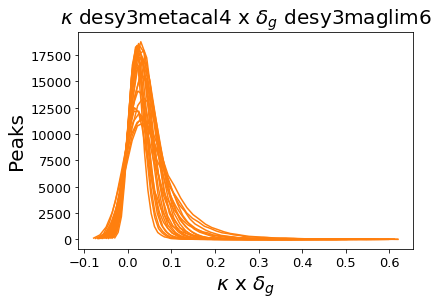

In [12]:
for bin_lensing in list_metacal:
    for bin_clustering in list_maglim:
        kg_metacal = sub_mean_kappa(kg_nobaryons[bin_lensing])
        dg_maglim = sub_mean_delta(dg_nobaryons[bin_clustering])

        kg_alm = hp.sphtfunc.map2alm(kg_metacal)
        dg_alm = hp.sphtfunc.map2alm(dg_maglim)

        cross_map = hp.alm2map(np.sqrt(kg_alm)*np.sqrt(dg_alm), nside=512)

        cross_map_estats = map(polarizations = 'E', kappa_E = cross_map, NSIDE=512, scales = [13.2])

        peaks_cross = cross_map_estats.calc_summary_stats(statistics=['Peaks'])
        cross = peaks_cross['E']['Peaks']
        sum_data_cp = summary(min_count=30, Peaks_sliced_bins=50, NSIDE=512, scales = [13.2])
        sum_data_cp.readin_stat_data(cross, statistic='Peaks', meta_list=[(1)], parameters=['tomo'])
        sum_data_cp.generate_binning_scheme(statistics=['Peaks'], bin=1)
        sum_data_cp.downbin_data(statistics=['Peaks'])
        cross_bin_edges, cross_bin_centers = sum_data_cp.get_binning_scheme(statistic='Peaks', bin=1)
        cross_mean, cross_err, cross_cov = sum_data_cp.get_full_summary(statistic='Peaks')

        cross_bin_centers = cross_bin_centers.reshape(50)
        cross_mean = cross_mean.reshape(50)

        #np.save(f'/global/cscratch1/sd/vajani/DESY3/combined_probes/combined_probes/combined_peaks/output/cross_peaks/binning_scheme/cosmo_fiducial_kappa_{bin_lensing}_delta_{bin_clustering}.npy', [cross_bin_centers, cross_mean])
        np.save(f'/global/cscratch1/sd/vajani/DESY3/combined_probes/combined_probes/combined_peaks/output/cross_peaks/cosmology_sensitivity/{cosmo}/perm_000{index_perm}/{cosmo}_kappa_{bin_lensing}_delta_{bin_clustering}.npy', [cross_bin_centers, cross_mean])




        plt.plot(cross_bin_centers, cross_mean, color = 'tab:orange')
        plt.xlabel('$\kappa$ x $\delta_g$', fontsize = 20)
        plt.ylabel('Peaks', fontsize = 20)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.title(f'$\kappa$ {bin_lensing} x $\delta_g$ {bin_clustering}',fontsize = 20)
